In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True,
                                        transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data/', train=False, download=True,
                                        transform=transform)

train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
image, answer = train_data[0]

In [5]:
image.shape

torch.Size([3, 32, 32])

In [6]:
answer

1

In [7]:
batch_size = 100

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size,
                                           shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

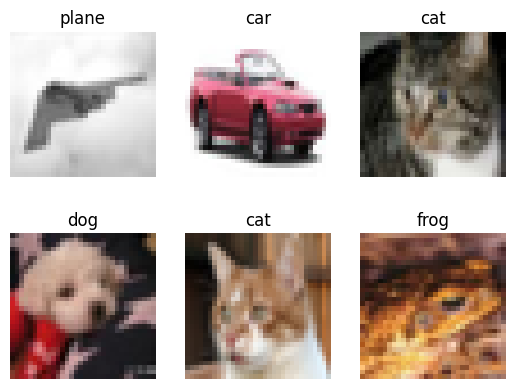

In [10]:
examples = iter(train_loader)
example_data, example_target = next(examples)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i].squeeze().permute(1, 2, 0) / 2 + 1 / 2)
    plt.title(classes[example_target[i].item()])
    plt.axis('off')

In [11]:
import torch.nn as nn

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
model = ConvNet()

In [14]:
model(example_data);

In [15]:
from torch.optim import Adam, SGD

In [16]:
loss = nn.CrossEntropyLoss()
opt = SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
%%time

best_val = 0
best_model = None
steps_without_improvement = 0

epoch = 0
while steps_without_improvement <= 5:
    for i, (images, target) in enumerate(train_loader):
        opt.zero_grad()
        
        outputs = model(images)
        err = loss(outputs, target)
        
        err.backward()
        opt.step()
        
        if (i + 1) % 100 == 0:
            print('Epoch ' + str(epoch) + ', Step [' + str(i + 1) + '/' + \
                  str(len(train_loader)) + ']' + ', Loss: ' + str(err.item()))
    
    
    with torch.no_grad():
        n_images = 0
        correct_images = 0
        for i, (images, target) in enumerate(val_loader):
            pred = model(images).max(-1).indices
            
            n_images += images.shape[0]
            correct_images += (pred == target).sum()
            
        val_res = correct_images / n_images
        
        print('\n==== Validation ====')
        print('Accuracy', val_res.item())
        print('====================')
        
        if val_res > best_val:
            best_val = val_res
            best_model = model.state_dict().copy()
            steps_without_improvement = 0
        else:
            steps_without_improvement += 1
            
    epoch += 1

Epoch 0, Step [100/400], Loss: 2.298041582107544
Epoch 0, Step [200/400], Loss: 2.2997541427612305
Epoch 0, Step [300/400], Loss: 2.2956156730651855
Epoch 0, Step [400/400], Loss: 2.3016879558563232

==== Validation ====
Accuracy 0.14000000059604645
Epoch 1, Step [100/400], Loss: 2.292503595352173
Epoch 1, Step [200/400], Loss: 2.2912981510162354
Epoch 1, Step [300/400], Loss: 2.291546106338501
Epoch 1, Step [400/400], Loss: 2.2755961418151855

==== Validation ====
Accuracy 0.19949999451637268
Epoch 2, Step [100/400], Loss: 2.2768807411193848
Epoch 2, Step [200/400], Loss: 2.251624822616577
Epoch 2, Step [300/400], Loss: 2.2151894569396973
Epoch 2, Step [400/400], Loss: 2.109670877456665

==== Validation ====
Accuracy 0.25440001487731934
Epoch 3, Step [100/400], Loss: 1.993370532989502
Epoch 3, Step [200/400], Loss: 1.924384593963623
Epoch 3, Step [300/400], Loss: 1.9960017204284668
Epoch 3, Step [400/400], Loss: 1.8607275485992432

==== Validation ====
Accuracy 0.29820001125335693
Epo

In [18]:
model.load_state_dict(best_model)

with torch.no_grad():
    n_images = 0
    correct_images = 0
    for images, targets in test_loader:
        outputs = model(images)
        
        predicted_classes = outputs.max(-1).indices
        n_images += images.shape[0]
        correct_images += (predicted_classes == targets).sum()
        
print(correct_images / n_images)

tensor(0.6278)
